In [11]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [ ]:
import math
import os
import time


import numpy as np
np.set_printoptions(legacy='1.25')

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product
import copy


from tqdm import tqdm

from scipy.stats import pearsonr
from importlib import reload

import orjson
import gzip



from lib import sketches, visualization_utils, encoders, ploting, pacha_sketch
reload(ploting)
reload(sketches)
reload(visualization_utils)
reload(encoders)

reload(pacha_sketch)

from lib.sketches import BloomFilter, CountMinSketch, H3HashFunctions, HashFunctionFamily,\
      CountMinSketchHadamard, CountMinSketchLocalHashing, deterministic_hash, simple_deterministic_hash
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes
from lib.encoders import minimal_b_adic_cover, minimal_spatial_b_adic_cover, BAdicCube, BAdicRange
from lib.pacha_sketch import PachaSketch, ADTree, BFParameters, CMParameters

from lib.ploting import set_style, plot_ylabel, plot_legend

from lib import baselines
reload(baselines)

from lib.baselines import CentralDPServer, LDPServer, LDPEncoderGRR, filter_df, query_df, \
      infer_domains_and_ranges, translate_query_region, evaluate_queries, check_accruracy, \
      evaluate_queries_baselines

# set_style()

In [13]:
delta = 0.05
abs_error_eps = 1.0

# Online Retail

In [14]:
retail_df = pd.read_parquet("../data/clean/online_retail.parquet")

In [15]:
query_path = "../queries/online_retail_2_cols.json"
with open(query_path, 'rb') as f:
    queries = orjson.loads(f.read())

ad_tree = ADTree.from_json("../sketches/ad_trees/online_retail.json")


In [21]:
p_sketch = PachaSketch.build_with_uniform_size(
    levels=5,
    num_dimensions=6,
    cat_col_map=[0,1,2],
    num_col_map=[3,4,5],
    bases=[2,2,2],
    ad_tree=ad_tree,
    cm_params=CMParameters(delta=delta, error_eps=abs_error_eps / len(retail_df)),
    cat_index_parameters=BFParameters(n_values=len(retail_df)*4, p=0.01),
    num_index_parameters=BFParameters(n_values=len(retail_df)*5, p=0.01),
    region_index_parameters= BFParameters(n_values=len(retail_df)*(5+4), p=0.01))
p_sketch.get_size()

95.50641822814941

In [22]:
p_sketch.update_data_frame(retail_df, workers=os.cpu_count())

Updating: 100%|██████████| 541909/541909 [04:18<00:00, 2093.36it/s]


In [44]:
p_sketch.save_to_file("../sketches/real_world/online_retail_uniform.json.gz")

In [ ]:
p_sketch2 = PachaSketch.from_json("../sketches/real_world/online_retail_uniform.json.gz")

In [ ]:
results_df = evaluate_queries(retail_df, queries["queries"], p_sketch, path_to_file="../results/real_world/online_retail_2_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:04<00:00, 43.34it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [23:24<00:00,  7.02s/it]


In [64]:
results_df[["absolute_error","normalized_error","relative_error","query_regions"]].describe()

,absolute_error,normalized_error,relative_error,query_regions
count,200.000000,200.000000,200.000000,200.000000
mean,1495.020000,0.002759,0.030890,13075.100000
std,3284.357086,0.006061,0.039216,22529.014215
min,3.000000,0.000006,0.003227,113.000000
25%,34.750000,0.000064,0.007233,546.750000
50%,206.000000,0.000380,0.012420,1768.000000
75%,862.250000,0.001591,0.052554,16739.500000
max,16057.000000,0.029630,0.247638,103413.000000


In [45]:
query_path = "../queries/online_retail_4_cols.json"
with open(query_path, 'rb') as f:
    queries_4 = orjson.loads(f.read())

In [46]:
results_df_4 = evaluate_queries(retail_df, queries_4["queries"], p_sketch, path_to_file="../results/real_world/online_retail_4_p_sketch_uniform.csv")

Computing true counts...


True Count: 100%|██████████| 200/200 [00:06<00:00, 30.75it/s]


Computing estimates...


Estimates: 100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


In [65]:
results_df_4[["absolute_error","normalized_error","relative_error","query_regions"]].describe()

/home/rudi/.local/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,absolute_error,normalized_error,relative_error,query_regions
count,200.000000,200.000000,195.000000,200.000000
mean,164.525000,0.000304,inf,1186.780000
std,438.239671,0.000809,NaN,3040.415082
min,0.000000,0.000000,0.000000,0.000000
25%,24.750000,0.000046,0.041999,212.000000
50%,45.500000,0.000084,0.063565,352.000000
75%,96.250000,0.000178,0.087964,597.750000
max,2792.000000,0.005152,inf,18121.000000


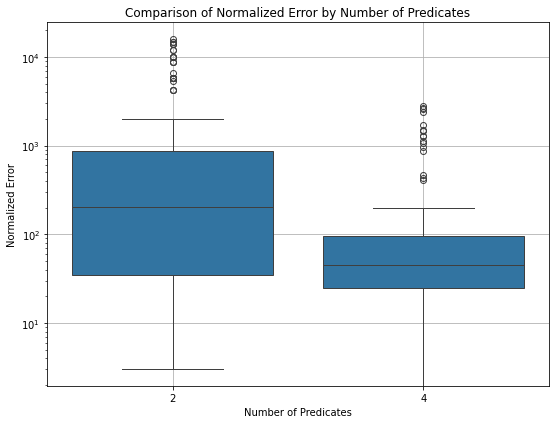

In [62]:
# Label the sources as '2' and '4' (corresponding to number of predicates)
results_df['num_predicates'] = '2'
results_df_4['num_predicates'] = '4'

# Combine the DataFrames
combined_df = pd.concat([results_df, results_df_4], ignore_index=True)

# Create the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='num_predicates', y='absolute_error', data=combined_df)

# Set axis labels and title
plt.xlabel('Number of Predicates')
plt.ylabel('Normalized Error')
plt.title('Comparison of Normalized Error by Number of Predicates')
plt.grid(True)
plt.tight_layout()
plt.yscale('log')  
plt.show()

In [ ]:
epsilon = 10.0
per_query_epsilon=epsilon/len(queries["queries"])
central_dp = CentralDPServer(retail_df, epsilon=epsilon, per_query_epsilon=per_query_epsilon)

central_dp_results = evaluate_queries_baselines()